### Technical challenge (05-Sep-2020)

Data available at [Open Data BCN](https://opendata-ajuntament.barcelona.cat/data/en/dataset/transit-relacio-trams)

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import datetime as dt
from scipy import stats
sns.set_style("darkgrid")
sns.despine()
sns.set_context(rc={'axes.labelsize':18,
                    'axes.titlesize':18,
                    'font.size':15,
                    'legend.fontsize':15,
                    'lines.linewidth':2.2})

<Figure size 432x288 with 0 Axes>

### Field information:

* idTram: Section identification number (more infomrmation in [Relació de trams de la via pública de la ciutat de Barcelona](https://opendata-ajuntament.barcelona.cat/data/en/dataset/transit-relacio-trams))

* data: Date of registration (format: YYYY-MM-DD)

* estatActual: Current traffic status
(0 = sense dades / 1 = molt fluid / 2 = fluid / 3 = dens / 4 = molt dens / 5 = congestió / 6 = tallat) 

* estatPrevist: Expected traffic status after 15min
(0 = sense dades / 1 = molt fluid / 2 = fluid / 3 = dens / 4 = molt dens / 5 = congestió / 6 = tallat) 

In [2]:
# There are 8 csv files from this year (Jan-Aug 2020).
# Load one of the files (2020-Jan) to check the contents.

tram_jan = pd.read_csv('./data/2020_01_Gener_TRAMS_TRAMS.csv')
print(tram_jan.shape)
tram_jan.head()

(4639708, 4)


,idTram,data,estatActual,estatPrevist
0,1,20200101000051,0,0
1,2,20200101000051,0,0
2,3,20200101000051,0,0
3,4,20200101000051,0,0
4,5,20200101000051,0,0


In [3]:
# Print data types
# Why: to check 'data' colmn is accessible by datetime module

tram_jan.dtypes

idTram          int64
data            int64
estatActual     int64
estatPrevist    int64
dtype: object

In [4]:
# Check if the data has corrupted points:
# 1. empty rows
# 2. duplicated data

print(f'Proportion of empty rows?: {tram_jan.isnull().any().mean()}')
print(f'Proportion of duplicated rows?: {tram_jan.duplicated().mean()}')

Proportion of empty rows?: 0.0
Proportion of duplicated rows?: 0.0


In [5]:
# Actually, null values in this dataset is presented with value '0'
# How many rows lacks data (value=0)?

no_data = (tram_jan['estatActual']==0) | (tram_jan['estatPrevist']==0)
print(f'How many rows lacks data (value=0)?: {len(tram_jan[no_data])}')

How many rows lacks data (value=0)?: 2257239


In [6]:
# Let's remove these raws without data:

tram_jan_clean = tram_jan[~no_data]
print(tram_jan_clean.shape)
tram_jan_clean.head()

(2382469, 4)


,idTram,data,estatActual,estatPrevist
96,97,20200101000051,1,5
142,143,20200101000051,1,5
156,157,20200101000051,1,5
187,188,20200101000051,1,5
273,274,20200101000051,3,5


### Note:
* All fields contain numeric values
* 'data' column should be converted to datetime type
* No duplicated records
* Missing values were removed

In [7]:
# Let's narrow our focus down to the Av. Diagonal of the city.
# These four attribute files were created by using QGIS software(QuickOSM plugin).

diagonal = pd.read_csv('./data/Diagonal.csv')
busstop = pd.read_csv('./data/nearest_busstop_distance.csv')
speedcamera = pd.read_csv('./data/nearest_speed_camera_distance.csv')
trafficsignal = pd.read_csv('./data/nearest-traffic_signals_distance.csv')

print(diagonal.shape) # If the section crosses with either primary or secondary streets
print(busstop.shape) # Distance to the nearest bus stop
print(speedcamera.shape) # Distance to the nearest speed camera
print(trafficsignal.shape) #  # Distance to the nearest traffic signal

(59, 4)
(118, 3)
(118, 3)
(118, 3)


In [8]:
print(diagonal.columns)
print(busstop.columns)
print(speedcamera.columns)
print(trafficsignal.columns)

Index(['Tram', 'Description', 'Primary', 'Secondary'], dtype='object')
Index(['Tram', 'BusstopID', 'Distance_busstop'], dtype='object')
Index(['Tram', 'MaxSpeed', 'Distance_camera'], dtype='object')
Index(['Tram', 'TrafficSignalID', 'Distance_trafficsignal'], dtype='object')


In [9]:
# Inner join of all 4 attributes(dataframes) on 'Tram' column

diagonal_merged = diagonal.merge(busstop, how='left', on='Tram', copy=False)
print(diagonal_merged.shape)

diagonal_merged = diagonal_merged.merge(speedcamera, how='left', on='Tram', copy=False)
print(diagonal_merged.shape)

diagonal_merged = diagonal_merged.merge(trafficsignal, how='left', on='Tram', copy=False)
print(diagonal_merged.shape)

diagonal_merged.head()

(118, 6)
(236, 8)
(472, 10)


,Tram,Description,Primary,Secondary,BusstopID,Distance_busstop,MaxSpeed,Distance_camera,TrafficSignalID,Distance_trafficsignal
0,1,Diagonal (Ronda de Dalt a Doctor Marañón),1.0,NaN,n5341631254,0.001115,80.0,0.006813,n1311619485,0.000266
1,1,Diagonal (Ronda de Dalt a Doctor Marañón),1.0,NaN,n5341631254,0.001115,80.0,0.006813,n6181436151,0.000206
2,1,Diagonal (Ronda de Dalt a Doctor Marañón),1.0,NaN,n5341631254,0.001115,50.0,0.002113,n1311619485,0.000266
3,1,Diagonal (Ronda de Dalt a Doctor Marañón),1.0,NaN,n5341631254,0.001115,50.0,0.002113,n6181436151,0.000206
4,1,Diagonal (Ronda de Dalt a Doctor Marañón),1.0,NaN,n5465386667,0.000540,80.0,0.006813,n1311619485,0.000266


In [10]:
# Let's keep one records per sectionID to keep the simplicity

diagonal_merged = diagonal_merged.drop_duplicates('Tram')
print(diagonal_merged.shape)

diagonal_merged.head()

(59, 10)


,Tram,Description,Primary,Secondary,BusstopID,Distance_busstop,MaxSpeed,Distance_camera,TrafficSignalID,Distance_trafficsignal
0,1,Diagonal (Ronda de Dalt a Doctor Marañón),1.0,NaN,n5341631254,0.001115,80.0,0.006813,n1311619485,0.000266
8,2,Diagonal (Doctor Marañón a Ronda de Dalt),1.0,NaN,n5341631254,0.000937,80.0,0.006554,n687897110,0.000176
16,3,Diagonal (Doctor Marañón a Pl. Pius XII),1.0,NaN,n5341631254,0.001152,80.0,0.006827,n687897110,0.000234
24,4,Diagonal (Pl. Pius XII a Doctor Marañón),1.0,NaN,n1478113760,0.000090,60.0,0.003019,n30314626,0.003206
32,5,Diagonal (Pl. Pius XII a Pl. Maria Cristina),1.0,NaN,n1478113760,0.000215,60.0,0.002824,n30314626,0.003008


In [11]:
# Are there any null values?

diagonal_merged.isnull().mean()

Tram                      0.000000
Description               0.000000
Primary                   0.610169
Secondary                 0.627119
BusstopID                 0.000000
Distance_busstop          0.000000
MaxSpeed                  0.762712
Distance_camera           0.000000
TrafficSignalID           0.000000
Distance_trafficsignal    0.000000
dtype: float64

In [12]:
# Impute nulls in 'Primary' and 'Secondary' columns with value '0'

diagonal_merged[['Primary', 'Secondary']] = diagonal_merged[['Primary', 'Secondary']].notnull()*1
diagonal_merged.isnull().mean()

Tram                      0.000000
Description               0.000000
Primary                   0.000000
Secondary                 0.000000
BusstopID                 0.000000
Distance_busstop          0.000000
MaxSpeed                  0.762712
Distance_camera           0.000000
TrafficSignalID           0.000000
Distance_trafficsignal    0.000000
dtype: float64

In [13]:
diagonal_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59 entries, 0 to 464
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Tram                    59 non-null     int64  
 1   Description             59 non-null     object 
 2   Primary                 59 non-null     int64  
 3   Secondary               59 non-null     int64  
 4   BusstopID               59 non-null     object 
 5   Distance_busstop        59 non-null     float64
 6   MaxSpeed                14 non-null     float64
 7   Distance_camera         59 non-null     float64
 8   TrafficSignalID         59 non-null     object 
 9   Distance_trafficsignal  59 non-null     float64
dtypes: float64(4), int64(3), object(3)
memory usage: 5.1+ KB


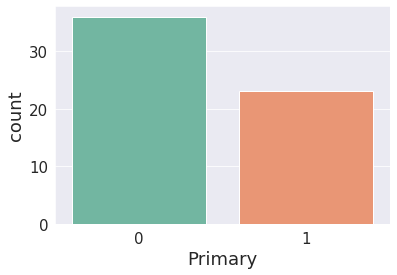

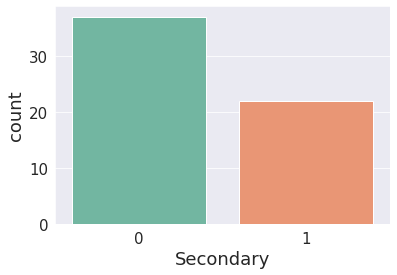

In [14]:
# Let's check distribution of numeric variables

sns.countplot(diagonal_merged.Primary, palette='Set2')
plt.show()
sns.countplot(diagonal_merged.Secondary, palette='Set2')
plt.show()

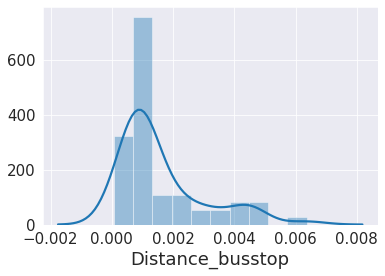

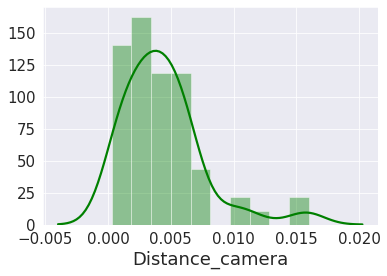

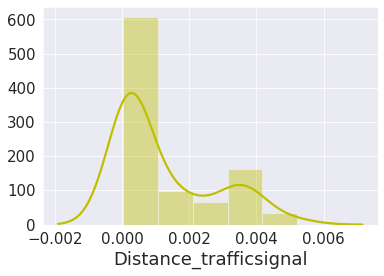

In [15]:
sns.distplot(diagonal_merged.Distance_busstop)
plt.show()

sns.distplot(diagonal_merged.Distance_camera, color='g')
plt.show()

sns.distplot(diagonal_merged.Distance_trafficsignal, color='y')
plt.show()

Check again the jan-2020 data focusing on these IDs (= secions located on Diagonal) only

In [16]:
# Extract Tram IDs in Diagonal:
sectionID = diagonal_merged.Tram.unique()
sectionID

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  19,  26,  27,
        47,  48,  49,  57,  63,  89, 101, 103, 104, 105, 106, 107, 122,
       180, 196, 197, 206, 239, 254, 256, 257, 258, 259, 260, 261, 265,
       272, 273, 279, 320, 360, 386, 387, 401, 402, 403, 413, 421, 423,
       424, 425, 426, 431, 447, 451, 517])

In [17]:
# Select only Diagonal-located sectionIDs from tram_jan_clean data
id_for_jan = [id for id in tram_jan_clean.idTram.unique() if id in sectionID]
print(len(id_for_jan))

# Filter january's clean data only using Diagonal's section ID
mask = tram_jan_clean['idTram'].isin(id_for_jan)
diagonal_jan = tram_jan_clean[mask]

print(diagonal_jan.shape)
diagonal_jan.head()

51
(297919, 4)


,idTram,data,estatActual,estatPrevist
1116,63,20200101001052,1,1
1175,122,20200101001052,1,2
1233,180,20200101001052,1,2
1259,206,20200101001052,2,2
1318,265,20200101001052,2,2


In [18]:
# Modify the data:
# 1. Change column names to english
# 2. Change 'date' column into datetime type

new_names = {"idTram": "Tram", "data": "date", "estatActual": "CurrentState", "estatPrevist": "ExpectedState"}
diagonal_jan = diagonal_jan.rename(columns=new_names)
    
# 2. 'date' column as a datetime type
diagonal_jan['date'] = pd.to_datetime(diagonal_jan['date'].astype(str), yearfirst=True)

diagonal_jan.head()

,Tram,date,CurrentState,ExpectedState
1116,63,2020-01-01 00:10:52,1,1
1175,122,2020-01-01 00:10:52,1,2
1233,180,2020-01-01 00:10:52,1,2
1259,206,2020-01-01 00:10:52,2,2
1318,265,2020-01-01 00:10:52,2,2


In [19]:
# Let's further modity the 'date' column

#1. Add day of the week info by creating a new column:
diagonal_jan['Weekday'] = diagonal_jan.date.dt.day_name()

#2. Let's introduce 'rush hour' to our data
rush_hour = diagonal_jan.CurrentState >= 5
diagonal_jan_rh = diagonal_jan[rush_hour]

diagonal_jan_rh.head()

,Tram,date,CurrentState,ExpectedState,Weekday
4473,258,2020-01-01 00:40:55,5,5,Wednesday
9805,320,2020-01-01 01:30:52,5,4,Wednesday
11324,258,2020-01-01 01:45:52,5,4,Wednesday
15602,320,2020-01-01 02:25:53,5,4,Wednesday
17648,258,2020-01-01 02:45:53,5,5,Wednesday


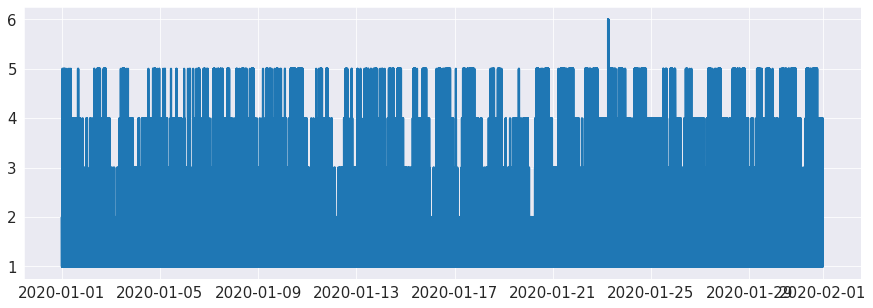

In [20]:
# Traffic states plotted by time

plt.figure(figsize=(15,5))
plt.plot(diagonal_jan.date, diagonal_jan.CurrentState)

Text(0.5, 0, 'Section ID')

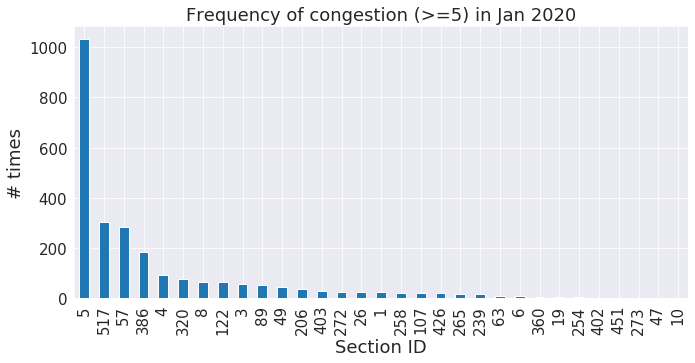

In [21]:
# Plot the frequency of congestion or blockage of traffic (CurrentState>=5)
# at each section IDs (of Diagonal's)

plt.figure(figsize=(11,5))
diagonal_jan_rh.Tram.value_counts().plot(kind='bar')
plt.title('Frequency of congestion (>=5) in Jan 2020')
plt.ylabel('# times')
plt.xlabel('Section ID')

In [22]:
# Select the top 10 most frequently congested sections
top10_id = diagonal_jan_rh.Tram.value_counts()[:10].index

mask = diagonal_jan_rh['Tram'] .isin(top10_id )
top10_congested = diagonal_jan_rh[mask]

print(top10_congested.shape)
print(f'top10 IDs: {top10_id}')
top10_congested.head()

(2211, 5)
top10 IDs: Int64Index([5, 517, 57, 386, 4, 320, 8, 122, 3, 89], dtype='int64')


,Tram,date,CurrentState,ExpectedState,Weekday
9805,320,2020-01-01 01:30:52,5,4,Wednesday
15602,320,2020-01-01 02:25:53,5,4,Wednesday
100976,320,2020-01-01 15:55:56,5,5,Wednesday
102030,320,2020-01-01 16:05:53,5,5,Wednesday
200579,320,2020-01-02 07:40:55,5,5,Thursday


In [23]:
# Join the diagonal_merged attributes to this top 10 IDs

top10_jan = top10_congested.merge(diagonal_merged, on='Tram', how='inner', copy=False)
print(top10_jan.shape)
top10_jan.head()

(2211, 14)


,Tram,date,CurrentState,ExpectedState,Weekday,Description,Primary,Secondary,BusstopID,Distance_busstop,MaxSpeed,Distance_camera,TrafficSignalID,Distance_trafficsignal
0,320,2020-01-01 01:30:52,5,4,Wednesday,Meridiana (Pl. de les Glòries a Aragó),0,0,n5760480313,0.001188,NaN,0.004786,n4637945307,0.000291
1,320,2020-01-01 02:25:53,5,4,Wednesday,Meridiana (Pl. de les Glòries a Aragó),0,0,n5760480313,0.001188,NaN,0.004786,n4637945307,0.000291
2,320,2020-01-01 15:55:56,5,5,Wednesday,Meridiana (Pl. de les Glòries a Aragó),0,0,n5760480313,0.001188,NaN,0.004786,n4637945307,0.000291
3,320,2020-01-01 16:05:53,5,5,Wednesday,Meridiana (Pl. de les Glòries a Aragó),0,0,n5760480313,0.001188,NaN,0.004786,n4637945307,0.000291
4,320,2020-01-02 07:40:55,5,5,Thursday,Meridiana (Pl. de les Glòries a Aragó),0,0,n5760480313,0.001188,NaN,0.004786,n4637945307,0.000291


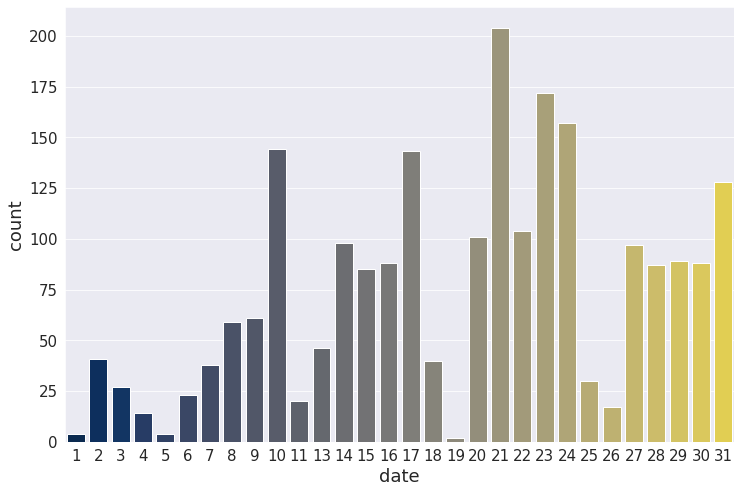

In [24]:
# Frequency of traffic congestion (>=5) in Jan, 2020
# Observation from top10 IDs
# Grouped by: date
 
plt.figure(figsize=(12,8))
sns.countplot(top10_jan.date.dt.day, palette='cividis')

Text(0.5, 1.0, 'Jan 2020')

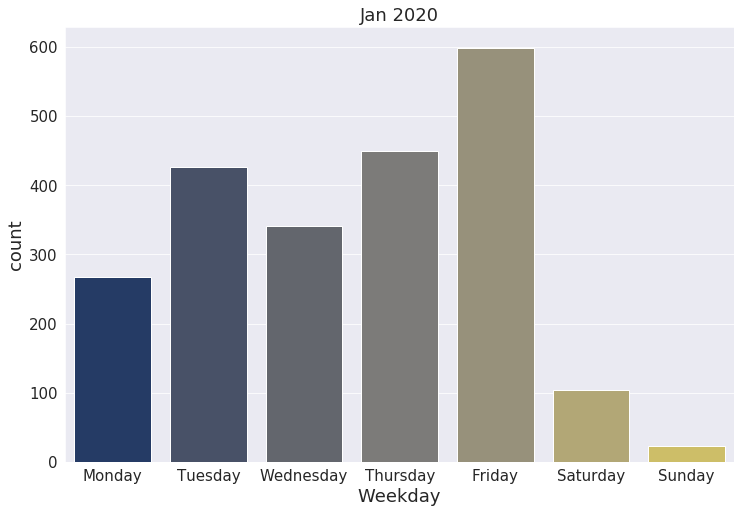

In [25]:
# Frequency of traffic congestion (>=5) in Jan, 2020
# Observation from top10 IDs
# Grouped by: weekday
 
plt.figure(figsize=(12,8))
order_of_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
sns.countplot(top10_jan.Weekday, palette='cividis', order=order_of_days)
plt.title('Jan 2020')

In [26]:
# Plot only Tuesday and Friday

only_tuesday_jan = top10_jan[top10_jan.Weekday == 'Tuesday']
only_friday_jan = top10_jan[top10_jan.Weekday == 'Friday']

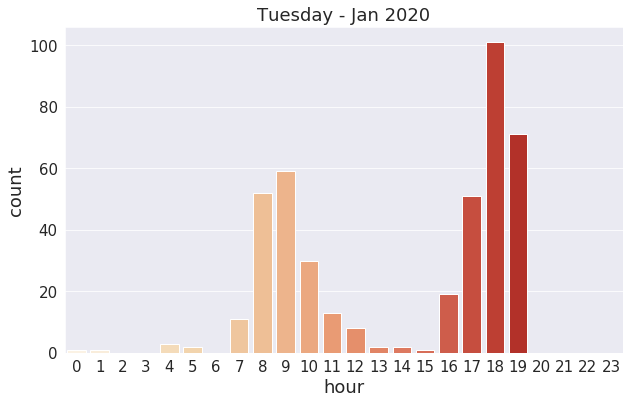

In [27]:
plt.figure(figsize=(10,6))
sns.countplot(only_tuesday_jan.date.dt.hour, palette='OrRd', order=np.arange(0,24))
plt.title('Tuesday - Jan 2020')
plt.xlabel('hour')
plt.show()

Text(0.5, 0, 'hour')

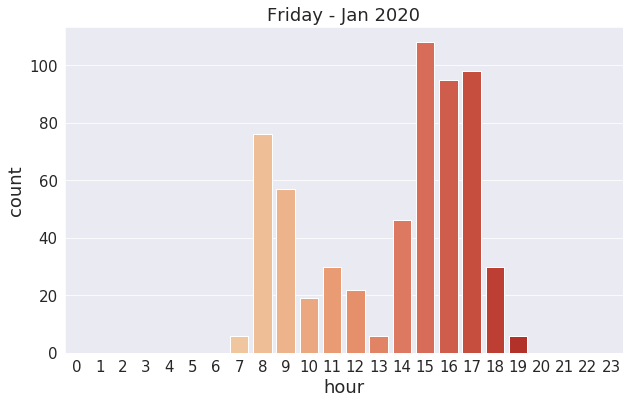

In [28]:
plt.figure(figsize=(10,6))
sns.countplot(only_friday_jan.date.dt.hour, palette='OrRd', order=np.arange(0,24))
plt.title('Friday - Jan 2020')
plt.xlabel('hour')

In [29]:
# Create a dataframe for the rest of the IDs

rest_id = diagonal_jan_rh.Tram.value_counts()[10:].index

mask = diagonal_jan_rh['Tram'].isin(rest_id )
rest_congested = diagonal_jan_rh[mask]

print(rest_congested.shape)
print(f'rest IDs: {rest_id}')

# Join the diagonal_merged attributes to these IDs

rest_jan = rest_congested.merge(diagonal_merged, on='Tram', how='inner', copy=False)
print(rest_jan.shape)
rest_jan.head()

(312, 5)
rest IDs: Int64Index([ 49, 206, 403, 272,  26,   1, 258, 107, 426, 265, 239,  63,   6,
            360,  19, 254, 402, 451, 273,  47,  10],
           dtype='int64')
(312, 14)


,Tram,date,CurrentState,ExpectedState,Weekday,Description,Primary,Secondary,BusstopID,Distance_busstop,MaxSpeed,Distance_camera,TrafficSignalID,Distance_trafficsignal
0,258,2020-01-01 00:40:55,5,5,Wednesday,Diagonal (Passeig de Sant Joan a Marina),0,0,n6321098314,0.002152,NaN,0.005648,n1311619461,0.000127
1,258,2020-01-01 01:45:52,5,4,Wednesday,Diagonal (Passeig de Sant Joan a Marina),0,0,n6321098314,0.002152,NaN,0.005648,n1311619461,0.000127
2,258,2020-01-01 02:45:53,5,5,Wednesday,Diagonal (Passeig de Sant Joan a Marina),0,0,n6321098314,0.002152,NaN,0.005648,n1311619461,0.000127
3,258,2020-01-01 03:10:53,5,5,Wednesday,Diagonal (Passeig de Sant Joan a Marina),0,0,n6321098314,0.002152,NaN,0.005648,n1311619461,0.000127
4,258,2020-01-01 04:10:52,5,5,Wednesday,Diagonal (Passeig de Sant Joan a Marina),0,0,n6321098314,0.002152,NaN,0.005648,n1311619461,0.000127


In [30]:
# ttest with the rest of the diagonal sections:

t_primary, p_primary = stats.ttest_ind(top10_jan.Primary, rest_jan.Primary)
t_secondary, p_secondary = stats.ttest_ind(top10_jan.Secondary, rest_jan.Secondary)

print(round(p_primary, 5))
print(round(p_secondary, 5))

0.00338
0.03392


In [31]:
print(f'top5 mean: {np.mean(top10_jan.Distance_busstop)}')
print(f'top5 std: {np.std(top10_jan.Distance_busstop)}')

print(f'rest mean: {np.mean(rest_jan.Distance_busstop)}')
print(f'rest std: {np.std(rest_jan.Distance_busstop)}')
print('-'*30)

print(f'top5 mean: {np.mean(top10_jan.Distance_camera)}')
print(f'top5 std: {np.std(top10_jan.Distance_camera)}')

print(f'rest mean: {np.mean(rest_jan.Distance_camera)}')
print(f'rest std: {np.std(rest_jan.Distance_camera)}')
print('-'*30)

print(f'top5 mean: {np.mean(top10_jan.Distance_trafficsignal)}')
print(f'top5 std: {np.std(top10_jan.Distance_trafficsignal)}')

print(f'rest mean: {np.mean(rest_jan.Distance_trafficsignal)}')
print(f'rest std: {np.std(rest_jan.Distance_trafficsignal)}')

top5 mean: 0.0015766926470976953
top5 std: 0.0021575041711928344
rest mean: 0.0016642782948130097
rest std: 0.0014252366466758874
------------------------------
top5 mean: 0.003414976803857543
top5 std: 0.0010161832835875024
rest mean: 0.00441075250756652
rest std: 0.004084519727003903
------------------------------
top5 mean: 0.0026649068678696393
top5 std: 0.0014693163707580898
rest mean: 0.0013008746537839103
rest std: 0.0014853291091070189


Text(0.5, 0, 'Distance unit')

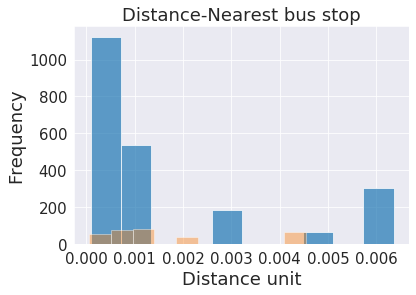

In [32]:
top10_jan.Distance_busstop.plot(kind='hist', alpha=.7)
rest_jan.Distance_busstop.plot(kind='hist', alpha=.4)
plt.title('Distance-Nearest bus stop')
plt.xlabel('Distance unit')

Text(0.5, 0, 'Distance unit')

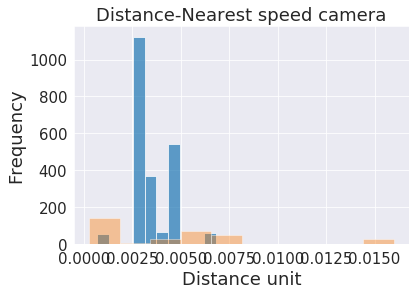

In [33]:
top10_jan.Distance_camera.plot(kind='hist', alpha=.7)
rest_jan.Distance_camera.plot(kind='hist', alpha=.4)
plt.title('Distance-Nearest speed camera')
plt.xlabel('Distance unit')

Text(0.5, 0, 'Distance unit')

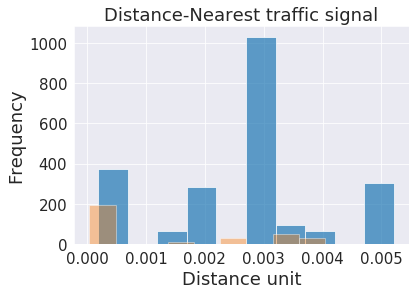

In [34]:
top10_jan.Distance_trafficsignal.plot(kind='hist', alpha=.7)
rest_jan.Distance_trafficsignal.plot(kind='hist', alpha=.4)
plt.title('Distance-Nearest traffic signal')
plt.xlabel('Distance unit')

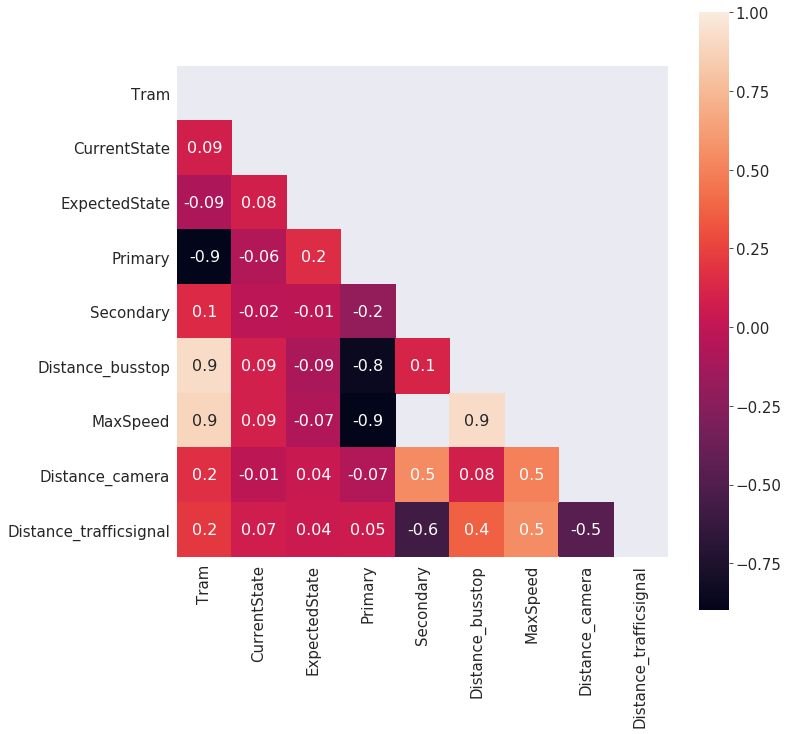

In [35]:
# Confusion matrix to show linear correaltion among all features

plt.figure(figsize=(11,11))
matrix = np.triu(top10_jan.corr())
sns.heatmap(top10_jan.corr(), annot=True, fmt='.1g', square=True, annot_kws={"size": 16}, mask=matrix)

In [36]:
# Is this tendency same in completely other moment of the year?
# May 2019 (more active moment of the year, only 1 festivo as in Jan 2020)

may_ = pd.read_csv('./data/2019_05_Maig_TRAMS_TRAMS.csv')
print(may_.shape)
may_.head()

(4637618, 4)


,idTram,data,estatActual,estatPrevist
0,1,20190501000552,1,0
1,2,20190501000552,1,0
2,3,20190501000552,1,0
3,4,20190501000552,1,0
4,5,20190501000552,1,0


In [37]:
# Check if there are corrupted data:
# 1. empty rows
# 2. duplicated data

print(f'Proportion of empty rows?: {may_.isnull().any().mean()}')
print(f'Proportion of duplicated rows?: {may_.duplicated().mean()}')

Proportion of empty rows?: 0.0
Proportion of duplicated rows?: 0.0


In [38]:
# Actually, null values in this dataset is presented with value '0'
# How many rows lacks data (value=0)?
no_data = (may_['estatActual']==0) | (may_['estatPrevist']==0)
print(f'How many rows lacks data (value=0)?: {len(may_[no_data])}')

How many rows lacks data (value=0)?: 2378753


In [39]:
# Let's remove these raws without data:

may_2019_clean = may_[~no_data]
print(may_2019_clean.shape)
may_2019_clean.head()

(2258865, 4)


,idTram,data,estatActual,estatPrevist
36,37,20190501000552,4,5
56,57,20190501000552,1,5
57,58,20190501000552,1,5
143,144,20190501000552,1,5
276,277,20190501000552,2,5


In [40]:
# Select IDs located on Av.Diagonal only

mask = may_2019_clean['idTram'].isin(id_for_jan)
diagonal_may = may_2019_clean[mask]

print(diagonal_may.shape)
diagonal_may.head()

(278133, 4)


,idTram,data,estatActual,estatPrevist
56,57,20190501000552,1,5
319,320,20190501000552,5,5
589,57,20190501000053,1,5
852,320,20190501000053,1,5
1066,1,20190501001053,1,1


In [41]:
# Modify the data:
# 1. Change column names to english
# 2. Change 'date' column into datetime type

diagonal_may = diagonal_may.rename(columns=new_names)
    
# 2. 'date' column as a datetime type
diagonal_may['date'] = pd.to_datetime(diagonal_may['date'].astype(str), yearfirst=True)

diagonal_may.head()

,Tram,date,CurrentState,ExpectedState
56,57,2019-05-01 00:05:52,1,5
319,320,2019-05-01 00:05:52,5,5
589,57,2019-05-01 00:00:53,1,5
852,320,2019-05-01 00:00:53,1,5
1066,1,2019-05-01 00:10:53,1,1


In [42]:
# Let's further modity the 'date' column

#1. Add day of the week info by creating a new column:
diagonal_may['Weekday'] = diagonal_may.date.dt.day_name()

#2. Let's introduce 'rush hour' to our data
rush_hour = diagonal_may.CurrentState >= 5
diagonal_may_rh = diagonal_may[rush_hour]

diagonal_may_rh.head()

,Tram,date,CurrentState,ExpectedState,Weekday
319,320,2019-05-01 00:05:52,5,5,Wednesday
2451,320,2019-05-01 00:20:52,5,4,Wednesday
10979,320,2019-05-01 01:40:52,5,2,Wednesday
15243,320,2019-05-01 02:20:53,5,5,Wednesday
18974,320,2019-05-01 02:55:52,5,5,Wednesday


Text(0.5, 0, 'Section ID')

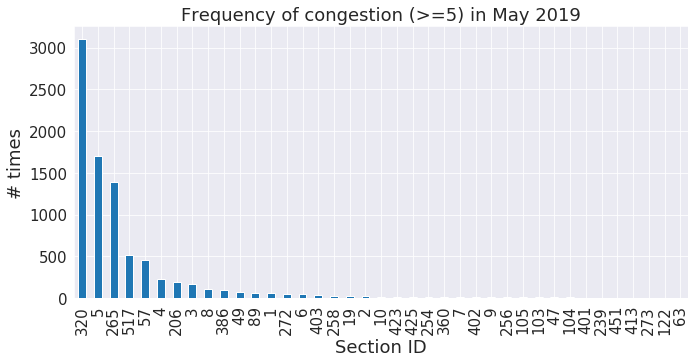

In [43]:
# Plot the frequency of congestion or blockage of traffic (CurrentState>=5)
# at each section IDs (of Diagonal's)

plt.figure(figsize=(11,5))
diagonal_may_rh.Tram.value_counts().plot(kind='bar')
plt.title('Frequency of congestion (>=5) in May 2019')
plt.ylabel('# times')
plt.xlabel('Section ID')

In [44]:
# Select the top 10 most frequently congested sections

top10_may = diagonal_may_rh.Tram.value_counts()[:10].index

mask = diagonal_may_rh['Tram'].isin(top10_may)
top10_may = diagonal_may_rh[mask]

print(top10_may.shape)

(7958, 5)


In [45]:
# Join with diagonal_merged attributes:
top10_may_id = top10_may['Tram'].unique()
top_ids = [id for id in top10_id if id in top10_may_id]

top10_may = top10_may.merge(diagonal_merged, on='Tram', how='inner', copy=False)
print(top10_may.shape)
top10_may.head()

(7958, 14)


,Tram,date,CurrentState,ExpectedState,Weekday,Description,Primary,Secondary,BusstopID,Distance_busstop,MaxSpeed,Distance_camera,TrafficSignalID,Distance_trafficsignal
0,320,2019-05-01 00:05:52,5,5,Wednesday,Meridiana (Pl. de les Glòries a Aragó),0,0,n5760480313,0.001188,NaN,0.004786,n4637945307,0.000291
1,320,2019-05-01 00:20:52,5,4,Wednesday,Meridiana (Pl. de les Glòries a Aragó),0,0,n5760480313,0.001188,NaN,0.004786,n4637945307,0.000291
2,320,2019-05-01 01:40:52,5,2,Wednesday,Meridiana (Pl. de les Glòries a Aragó),0,0,n5760480313,0.001188,NaN,0.004786,n4637945307,0.000291
3,320,2019-05-01 02:20:53,5,5,Wednesday,Meridiana (Pl. de les Glòries a Aragó),0,0,n5760480313,0.001188,NaN,0.004786,n4637945307,0.000291
4,320,2019-05-01 02:55:52,5,5,Wednesday,Meridiana (Pl. de les Glòries a Aragó),0,0,n5760480313,0.001188,NaN,0.004786,n4637945307,0.000291


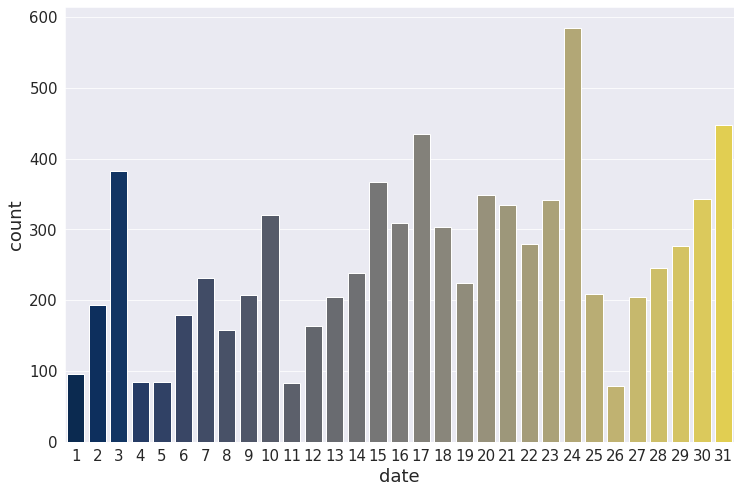

In [46]:
# Frequency of traffic congestion (>=5) in May, 2019
# Observation from top10 IDs
# Grouped by: date
 
plt.figure(figsize=(12,8))
sns.countplot(top10_may.date.dt.day, palette='cividis')

Text(0.5, 1.0, 'May 2019')

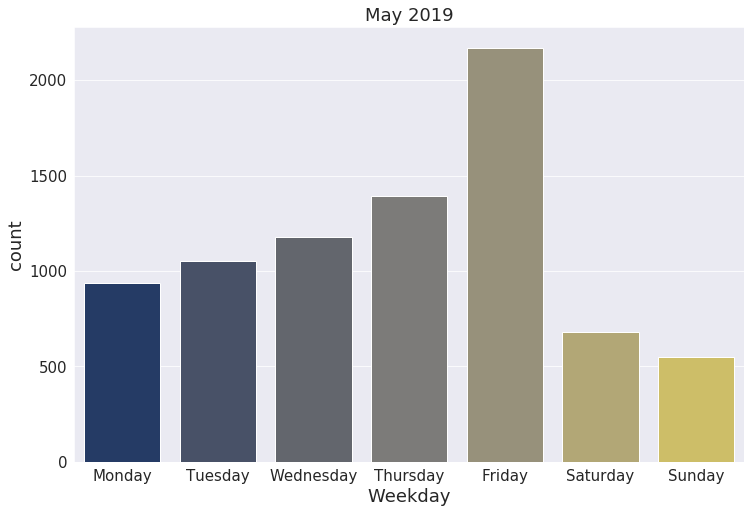

In [47]:
# Frequency of traffic congestion (>=5) in May, 2019
# Observation from top10 IDs
# Grouped by: weekday
 
plt.figure(figsize=(12,8))
order_of_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
sns.countplot(top10_may.Weekday, palette='cividis', order=order_of_days)
plt.title('May 2019')

In [48]:
only_tuesday_may = top10_may[top10_may.Weekday == 'Tuesday']
only_friday_may = top10_may[top10_may.Weekday == 'Friday']

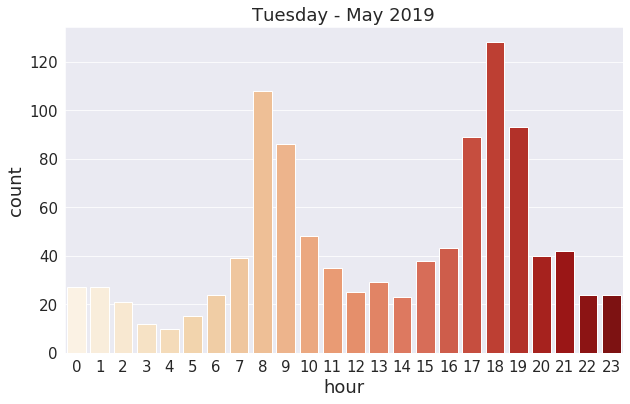

In [49]:
plt.figure(figsize=(10,6))
sns.countplot(only_tuesday_may.date.dt.hour, palette='OrRd', order=np.arange(0,24))
plt.title('Tuesday - May 2019')
plt.xlabel('hour')
plt.show()

Text(0.5, 0, 'hour')

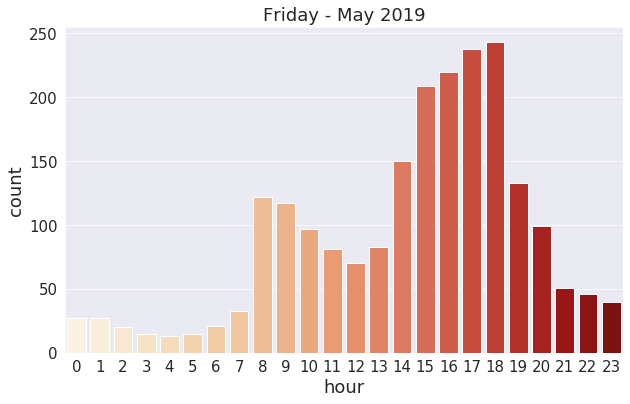

In [50]:
plt.figure(figsize=(10,6))
sns.countplot(only_friday_may.date.dt.hour, palette='OrRd', order=np.arange(0,24))
plt.title('Friday - May 2019')
plt.xlabel('hour')

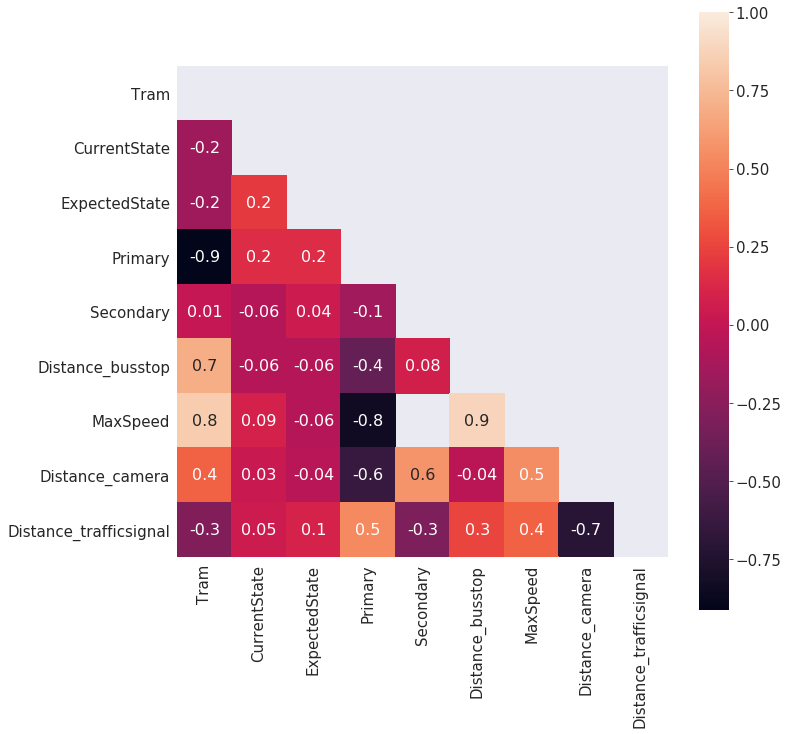

In [51]:
# Confusion matrix to show linear correaltion among all features

plt.figure(figsize=(11,11))
matrix = np.triu(top10_may.corr())
sns.heatmap(top10_may.corr(), annot=True, fmt='.1g', square=True, annot_kws={"size": 16}, mask=matrix)

In [52]:
# There are overlapping section IDs between Jan-2020 and May-2019 data

overlap_IDs = [i for i in top10_jan.Tram.unique() if i in top10_may_id]
overlap_IDs


[320, 5, 517, 386, 4, 57, 8, 3]

In [53]:
mask = diagonal_merged['Tram'].isin(overlap_IDs)
diagonal_merged[mask][['Tram','Description']]

,Tram,Description
16,3,Diagonal (Doctor Marañón a Pl. Pius XII)
24,4,Diagonal (Pl. Pius XII a Doctor Marañón)
32,5,Diagonal (Pl. Pius XII a Pl. Maria Cristina)
56,8,Diagonal (Numància a Pl. Maria Cristina)
128,57,Ganduxer (Diagonal a Pl. Gregori Tramaturg)
336,320,Meridiana (Pl. de les Glòries a Aragó)
352,386,Consell de Cent (Av. Diagonal a Av. Meridiana)
464,517,Ronda de Dalt (Diagonal a Carretera d'Esplugues)


# Modeling

In [54]:
diagonal_jan.head()

,Tram,date,CurrentState,ExpectedState,Weekday
1116,63,2020-01-01 00:10:52,1,1,Wednesday
1175,122,2020-01-01 00:10:52,1,2,Wednesday
1233,180,2020-01-01 00:10:52,1,2,Wednesday
1259,206,2020-01-01 00:10:52,2,2,Wednesday
1318,265,2020-01-01 00:10:52,2,2,Wednesday


In [55]:
jan_model = diagonal_jan.merge(diagonal_merged, on='Tram', how='left', copy=False)

In [56]:
# First, check all csv files of this directory
file_list = [file for file in glob.glob("./data/traffic/first-half/*.csv")]
# Sort the list by ascending order
file_list = np.sort(file_list)

In [57]:
file_list

array(['./data/traffic/first-half/2019_01_Gener_TRAMS_TRAMS.csv',
       './data/traffic/first-half/2019_02_Febrer_TRAMS_TRAMS.csv',
       './data/traffic/first-half/2019_03_Marc_TRAMS_TRAMS.csv',
       './data/traffic/first-half/2019_04_Abril_TRAMS_TRAMS.csv',
       './data/traffic/first-half/2019_05_Maig_TRAMS_TRAMS.csv',
       './data/traffic/first-half/2019_06_Juny_TRAMS_TRAMS.csv',
       './data/traffic/first-half/2019_07_Juliol_TRAMS_TRAMS.csv'],
      dtype='<U56')

In [58]:
# Each file is big -> don't concatenate
# Use list comprehension to crete a list of multiple dataframes
traffics = [pd.read_csv(file) for file in file_list]

In [59]:
traffic_df = pd.DataFrame()

for traffic in traffics:
    no_data = (traffic['estatActual']==0) | (traffic['estatPrevist']==0)  # value 0: no data
    traffic_clean = traffic[~no_data] # Remove 'no data' rows
    mask = traffic_clean['idTram'].isin(overlap_IDs) # select only the most busy section IDs
    traffic_top8 = traffic_clean[mask]
    traffic_df = traffic_df.append(traffic_top8)

traffic_df.head()

,idTram,data,estatActual,estatPrevist
537,5,20190101003550,1,2
540,8,20190101003550,1,1
918,386,20190101003550,1,1
1042,517,20190101003550,1,1
1070,5,20190101010051,2,2


In [60]:
traffic_df.shape

(216122, 4)

In [61]:
# Modify the data:
# 1. Change column names to english
# 2. Change 'date' column into datetime type

new_names = {"idTram": "Tram", "data": "date", "estatActual": "CurrentState", "estatPrevist": "ExpectedState"}
traffic_df = traffic_df.rename(columns=new_names)
    
# 2. 'date' column as a datetime type
traffic_df['date'] = pd.to_datetime(traffic_df['date'].astype(str), yearfirst=True)

traffic_df.head()

,Tram,date,CurrentState,ExpectedState
537,5,2019-01-01 00:35:50,1,2
540,8,2019-01-01 00:35:50,1,1
918,386,2019-01-01 00:35:50,1,1
1042,517,2019-01-01 00:35:50,1,1
1070,5,2019-01-01 01:00:51,2,2


In [62]:
# Add day of the week info by creating a new column:
traffic_df['Weekday'] = traffic_df.date.dt.day_name()

traffic_df.head()

,Tram,date,CurrentState,ExpectedState,Weekday
537,5,2019-01-01 00:35:50,1,2,Tuesday
540,8,2019-01-01 00:35:50,1,1,Tuesday
918,386,2019-01-01 00:35:50,1,1,Tuesday
1042,517,2019-01-01 00:35:50,1,1,Tuesday
1070,5,2019-01-01 01:00:51,2,2,Tuesday


In [63]:
# Join with diagonal_merged attributes:

traffic_df = traffic_df.merge(diagonal_merged, on='Tram', how='inner', copy=False)
print(traffic_df.shape)
traffic_df.head()

(216122, 14)


,Tram,date,CurrentState,ExpectedState,Weekday,Description,Primary,Secondary,BusstopID,Distance_busstop,MaxSpeed,Distance_camera,TrafficSignalID,Distance_trafficsignal
0,5,2019-01-01 00:35:50,1,2,Tuesday,Diagonal (Pl. Pius XII a Pl. Maria Cristina),1,0,n1478113760,0.000215,60.0,0.002824,n30314626,0.003008
1,5,2019-01-01 01:00:51,2,2,Tuesday,Diagonal (Pl. Pius XII a Pl. Maria Cristina),1,0,n1478113760,0.000215,60.0,0.002824,n30314626,0.003008
2,5,2019-01-01 01:30:52,2,3,Tuesday,Diagonal (Pl. Pius XII a Pl. Maria Cristina),1,0,n1478113760,0.000215,60.0,0.002824,n30314626,0.003008
3,5,2019-01-01 01:55:53,2,3,Tuesday,Diagonal (Pl. Pius XII a Pl. Maria Cristina),1,0,n1478113760,0.000215,60.0,0.002824,n30314626,0.003008
4,5,2019-01-01 02:25:52,1,1,Tuesday,Diagonal (Pl. Pius XII a Pl. Maria Cristina),1,0,n1478113760,0.000215,60.0,0.002824,n30314626,0.003008


# Multiclass Classification by Decision Tree

# Target: Current State


### Feature entigeering

In [64]:
traffic = traffic_df.copy()

In [65]:
# Remove columns that are irrelevant to predict Current state

traffic.drop(['ExpectedState', 'Description', 'BusstopID', 'TrafficSignalID'], axis=1, inplace=True)
traffic.head()

,Tram,date,CurrentState,Weekday,Primary,Secondary,Distance_busstop,MaxSpeed,Distance_camera,Distance_trafficsignal
0,5,2019-01-01 00:35:50,1,Tuesday,1,0,0.000215,60.0,0.002824,0.003008
1,5,2019-01-01 01:00:51,2,Tuesday,1,0,0.000215,60.0,0.002824,0.003008
2,5,2019-01-01 01:30:52,2,Tuesday,1,0,0.000215,60.0,0.002824,0.003008
3,5,2019-01-01 01:55:53,2,Tuesday,1,0,0.000215,60.0,0.002824,0.003008
4,5,2019-01-01 02:25:52,1,Tuesday,1,0,0.000215,60.0,0.002824,0.003008


In [66]:
traffic['Weekday'] = traffic['Weekday'].map({'Sunday':0, 'Monday':1, 'Tuesday':2, 'Wednesday':3, 'Thursday':4, 'Friday':5, 'Saturday':6})
traffic.head()

,Tram,date,CurrentState,Weekday,Primary,Secondary,Distance_busstop,MaxSpeed,Distance_camera,Distance_trafficsignal
0,5,2019-01-01 00:35:50,1,2,1,0,0.000215,60.0,0.002824,0.003008
1,5,2019-01-01 01:00:51,2,2,1,0,0.000215,60.0,0.002824,0.003008
2,5,2019-01-01 01:30:52,2,2,1,0,0.000215,60.0,0.002824,0.003008
3,5,2019-01-01 01:55:53,2,2,1,0,0.000215,60.0,0.002824,0.003008
4,5,2019-01-01 02:25:52,1,2,1,0,0.000215,60.0,0.002824,0.003008


In [67]:
traffic['month'] = traffic['date'].dt.month
traffic['day'] = traffic['date'].dt.day
traffic['hour'] = traffic['date'].dt.hour
traffic.drop('date', axis=1, inplace=True)
traffic.head()

,Tram,CurrentState,Weekday,Primary,Secondary,Distance_busstop,MaxSpeed,Distance_camera,Distance_trafficsignal,month,day,hour
0,5,1,2,1,0,0.000215,60.0,0.002824,0.003008,1,1,0
1,5,2,2,1,0,0.000215,60.0,0.002824,0.003008,1,1,1
2,5,2,2,1,0,0.000215,60.0,0.002824,0.003008,1,1,1
3,5,2,2,1,0,0.000215,60.0,0.002824,0.003008,1,1,1
4,5,1,2,1,0,0.000215,60.0,0.002824,0.003008,1,1,2


In [68]:
# impute MaxSpeed

traffic['MaxSpeed'].fillna(traffic['MaxSpeed'].mode()[0], inplace=True)

In [69]:
traffic.isnull().mean()

Tram                      0.0
CurrentState              0.0
Weekday                   0.0
Primary                   0.0
Secondary                 0.0
Distance_busstop          0.0
MaxSpeed                  0.0
Distance_camera           0.0
Distance_trafficsignal    0.0
month                     0.0
day                       0.0
hour                      0.0
dtype: float64

In [70]:
traffic.CurrentState.value_counts(normalize=True)

2    0.490593
1    0.255874
5    0.092263
3    0.082648
4    0.077294
6    0.001328
Name: CurrentState, dtype: float64

In [71]:
features = [col for col in traffic.columns if col != 'CurrentState']
features

['Tram',
 'Weekday',
 'Primary',
 'Secondary',
 'Distance_busstop',
 'MaxSpeed',
 'Distance_camera',
 'Distance_trafficsignal',
 'month',
 'day',
 'hour']

In [72]:
X = traffic[features]
y = traffic['CurrentState']

In [73]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

In [74]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(162091, 11)
(54031, 11)
(162091,)
(54031,)


In [75]:
classes = ['very fluid', 'fluid', 'dense', 'very dense', 'congestion', 'blocked']

In [76]:
class_weight = {1:0.2, 2:0.2, 3:2, 4:2, 5:2, 6:4}

In [77]:
# Fitting Classifier to the Training Set
from sklearn.tree import DecisionTreeClassifier

classifier = DecisionTreeClassifier(criterion='entropy', max_depth=16, random_state=21, class_weight={3:10, 4:10, 5:10, 6:10})#, class_weight=class_weight)
classifier.fit(X_train, y_train)

DecisionTreeClassifier(class_weight={3: 10, 4: 10, 5: 10, 6: 10},
                       criterion='entropy', max_depth=16, random_state=21)

In [78]:
# Model performance on training set
y_pred_train =classifier.predict(X_train)

from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report

accuracy = metrics.accuracy_score(y_train, y_pred_train)
print("Accuracy: {:.2f}".format(accuracy))

cm=confusion_matrix(y_train,y_pred_train)
print('Confusion Matrix: \n', cm)
print(classification_report(y_train, y_pred_train, target_names=classes))

Accuracy: 0.71
Confusion Matrix: 
 [[35164  4424   995   567   269    19]
 [ 3800 52595 14989  3997  4211    14]
 [    8   721  8755  2623  1207     1]
 [    0   288  2716  7224  2272     0]
 [    0   173   786  2348 11697     0]
 [    0     6     0     0     0   222]]
              precision    recall  f1-score   support

  very fluid       0.90      0.85      0.87     41438
       fluid       0.90      0.66      0.76     79606
       dense       0.31      0.66      0.42     13315
  very dense       0.43      0.58      0.49     12500
  congestion       0.60      0.78      0.67     15004
     blocked       0.87      0.97      0.92       228

    accuracy                           0.71    162091
   macro avg       0.67      0.75      0.69    162091
weighted avg       0.79      0.71      0.73    162091



In [79]:
# Predicting the test results
y_pred=classifier.predict(X_test)

# Classification results on test set
accuracy = metrics.accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}".format(accuracy))

cm=confusion_matrix(y_test,y_pred)
print('Confusion Matrix: \n', cm)
print(classification_report(y_test, y_pred, target_names=classes))

Accuracy: 0.68
Confusion Matrix: 
 [[11489  1733   356   182    91    11]
 [ 1461 17054  5148  1334  1423     2]
 [   20   350  2638  1054   485     0]
 [    8   133  1024  2148   892     0]
 [    5   105   332   943  3549     2]
 [    0     3     0     0     0    56]]
              precision    recall  f1-score   support

  very fluid       0.88      0.83      0.86     13862
       fluid       0.88      0.65      0.74     26422
       dense       0.28      0.58      0.38      4547
  very dense       0.38      0.51      0.44      4205
  congestion       0.55      0.72      0.62      4936
     blocked       0.79      0.95      0.86        59

    accuracy                           0.68     54031
   macro avg       0.63      0.71      0.65     54031
weighted avg       0.76      0.68      0.71     54031



In [80]:
# Visualize the tree by graphiz
# import graphviz
# from sklearn import tree
# feature_names = features
# dot_data = tree.export_graphviz(classifier, out_file=None, filled=True, rounded = True, feature_names=feature_names, class_names=classes)
# graph = graphviz.Source(dot_data)
# graph

In [81]:
from sklearn.ensemble import RandomForestClassifier

In [82]:
# Fitting Random Forest Classification to the Training set
randomforest = RandomForestClassifier(n_estimators=120, max_depth=17,
                                      criterion='entropy', random_state=21, class_weight={3:15, 4:15, 5:15, 6:15})
randomforest.fit(X_train, y_train)

RandomForestClassifier(class_weight={3: 15, 4: 15, 5: 15, 6: 15},
                       criterion='entropy', max_depth=17, n_estimators=120,
                       random_state=21)

In [83]:
# Model performance on training set
y_pred_train_rf =randomforest.predict(X_train)

accuracy = metrics.accuracy_score(y_train, y_pred_train_rf)
print("Accuracy: {:.2f}".format(accuracy))

cm=confusion_matrix(y_train,y_pred_train_rf)
print('Confusion Matrix: \n', cm)
print(classification_report(y_train, y_pred_train_rf, target_names=classes))

Accuracy: 0.75
Confusion Matrix: 
 [[36238  4011   583   372   215    19]
 [ 3420 56529 13175  3480  2988    14]
 [   10   375  9402  2265  1262     1]
 [    3   128  2477  7501  2391     0]
 [    1    49   618  1867 12469     0]
 [    0     5     1     0     0   222]]
              precision    recall  f1-score   support

  very fluid       0.91      0.87      0.89     41438
       fluid       0.93      0.71      0.80     79606
       dense       0.36      0.71      0.48     13315
  very dense       0.48      0.60      0.54     12500
  congestion       0.65      0.83      0.73     15004
     blocked       0.87      0.97      0.92       228

    accuracy                           0.75    162091
   macro avg       0.70      0.78      0.73    162091
weighted avg       0.82      0.75      0.77    162091



In [84]:
# Predicting the test results
y_pred_rf=randomforest.predict(X_test)

# Classification results on test set
accuracy = metrics.accuracy_score(y_test, y_pred_rf)
print("Accuracy: {:.2f}".format(accuracy))

cm=confusion_matrix(y_test,y_pred_rf)
print('Confusion Matrix: \n', cm)
print(classification_report(y_test, y_pred_rf, target_names=classes))

Accuracy: 0.72
Confusion Matrix: 
 [[11818  1642   178   140    73    11]
 [ 1405 18286  4558  1186   985     2]
 [   22   344  2734   959   488     0]
 [    9   117   991  2102   986     0]
 [    5    52   275   802  3800     2]
 [    0     2     1     0     0    56]]
              precision    recall  f1-score   support

  very fluid       0.89      0.85      0.87     13862
       fluid       0.89      0.69      0.78     26422
       dense       0.31      0.60      0.41      4547
  very dense       0.41      0.50      0.45      4205
  congestion       0.60      0.77      0.67      4936
     blocked       0.79      0.95      0.86        59

    accuracy                           0.72     54031
   macro avg       0.65      0.73      0.67     54031
weighted avg       0.78      0.72      0.74     54031

